It is very difficult to process 120 classes with the colab GPU so this colab notebook uses 16 classes of breeds for getting the final output

In [0]:
import cv2
import numpy as np
import pandas as pd
import os


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
project_path = '/content/drive/My Drive/deep learning/Residency 8/Projects/Computer Vision/DogBreed_Classification/'

In [31]:
import pandas as pd
labels_df = pd.read_csv(project_path+'labels.csv.zip')
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


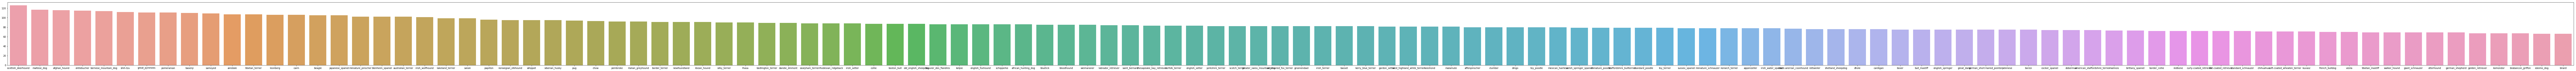

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (200,5))

#value_counts function considers the calling object with indices and gives the count of each index value. 
#Thus breed_cnt.index contains the breeds as indices and count displayed on the vertical axis. 

breed_cnt = labels_df['breed'].value_counts()
sns.barplot(breed_cnt.index, breed_cnt.values, alpha=0.9)
plt.show()

In [33]:
#retaining just 16 indices(breeds) for memory related issues

sublist = []
sublist = breed_cnt.index[0:16]
sublist


Index(['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher',
       'bernese_mountain_dog', 'shih-tzu', 'great_pyrenees', 'pomeranian',
       'basenji', 'samoyed', 'airedale', 'tibetan_terrier', 'leonberg',
       'cairn', 'beagle', 'japanese_spaniel'],
      dtype='object')

In [0]:
for i in range(labels_df.shape[0]):
  labels_new_df = labels_df[labels_df['breed'].isin(sublist)]

In [35]:
labels_new_df.shape

(1777, 2)

In [0]:
x_train = []
y_train = []

for img_id in labels_new_df['id']:
  temp_x = cv2.imread(project_path+'train/'+img_id+'.jpg')
  temp_x = cv2.resize(temp_x,(224,224))
  x_train.append(temp_x)
  temp_y = np.asarray(labels_new_df.loc[labels_new_df.id == img_id , 'breed'])
  y_train.append(temp_y)
  

In [0]:
import numpy as np
X_arr = np.asarray(x_train)
np.save(project_path+'X_arr_short.npy', X_arr)

Saving train images upload to a numpy array so that it can be reused in subsequent sessions

In [0]:
import keras
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_breed = le.fit_transform(labels_new_df['breed'])
y_breed_arr = keras.utils.to_categorical(y_breed, num_classes=16)

In [39]:
y_breed.dtype

dtype('int64')

In [40]:
y_breed

array([ 2, 13, 10, ...,  1, 12,  1])

In [41]:
y_breed_arr.shape

(1777, 16)

In [0]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(X_arr,
	y_breed, test_size=0.2, random_state=1)

In [43]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(1421, 224, 224, 3)
(356, 224, 224, 3)
(1421,)
(356,)


In [44]:
trainY

array([ 6, 14,  3, ..., 13, 13,  0])

In [0]:
trainX = trainX.astype('float32')
trainX /=255


testX = testX.astype('float32')
testX /=255

Transfer learning using VGG16

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
#note : VGG16 requires image shape to be (224,224,3)

base_model1=VGG16(weights=('imagenet'),
                 include_top= False, pooling = 'avg', input_shape=(224,224,3))

In [47]:
#train_vgg_bf = base_model1.predict_generator(train_datagen.flow(trainX, trainY, batch_size=32), steps=500, verbose=1)
train_vgg = base_model1.predict(trainX, batch_size=32, verbose=1)

1421/1421 [==============================] - 687s 484ms/step


In [48]:
#val_vgg_bf = base_model1.predict_generator(val_datagen.flow(testX, testY, batch_size=32), steps=500, verbose=1)
valid_vgg = base_model1.predict(testX, batch_size=32, verbose=1)

356/356 [==============================] - 172s 483ms/step


In [49]:
train_vgg.shape

(1421, 512)

We can choose to do softmax or mutinomial logistic regression as this is a multi class classifier.

In [50]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', random_state = 1)

logreg.fit(train_vgg, (trainY))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
from sklearn.metrics import log_loss, accuracy_score
valid_probs = logreg.predict_proba(valid_vgg)
valid_preds = logreg.predict(valid_vgg)
print('Validation VGG LogLoss {}'.format(log_loss(testY, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score(testY , valid_preds)))

Validation VGG LogLoss 1.1094601295420148
Validation VGG Accuracy 0.6685393258426966


With Data Augmentation, let's look at the accuracy


In [0]:
x_train = []
y_train = []

for img_id in labels_new_df['id']:
  temp_x = cv2.imread(project_path+'train/'+img_id+'.jpg')
  temp_x = cv2.resize(temp_x,(224,224))
  x = preprocess_input(temp_x)
  x_train.append(x)
  
  

In [0]:

X_arr = np.asarray(x_train)


In [0]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(X_arr,
	y_breed, test_size=0.2, random_state=1)

train_vgg_aug here stands for training on augmented images

In [55]:
train_vgg_aug = base_model1.predict(trainX, batch_size=32, verbose=1)

1421/1421 [==============================] - 686s 483ms/step


In [56]:
valid_vgg_aug = base_model1.predict(testX, batch_size=32, verbose=1)

356/356 [==============================] - 172s 482ms/step


In [59]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1)
logreg.fit(train_vgg_aug, trainY)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
from sklearn.metrics import log_loss, accuracy_score
valid_probs = logreg.predict_proba(valid_vgg_aug)
valid_preds = logreg.predict(valid_vgg_aug)
print('Validation VGG LogLoss {}'.format(log_loss(testY, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score(testY , valid_preds)))

Validation VGG LogLoss 0.5257176704232227
Validation VGG Accuracy 0.8876404494382022
